This notebook handles reviwer comments on our paper. In particular, the question was if other eigenvectors of the usroad network showed better structure. (Or showed any city structure.)

Here we plot the first few eigenvectors and the road pictures.
This makes files 

usroads-spectral-embed-1-3
usroads-spectral-embed-1-4
usroads-spectral-embed-2-3
usroads-spectral-embed-2-4
usroads-spectral-embed-3-4

In [1]:
import localgraphclustering as lgc
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
import matplotlib.patheffects as path_effects
# shapefile names 
riverslakes_shape='ne_50m_rivers_lake_centerlines_scale_rank'
lakes_shape='ne_50m_lakes'

In [2]:
# I don't understand why, but this needs to be in it's own cell...
plt.rcParams['figure.dpi'] = 200
# Only run this if you want high-quality intermediate figures -- but they get BIG! 

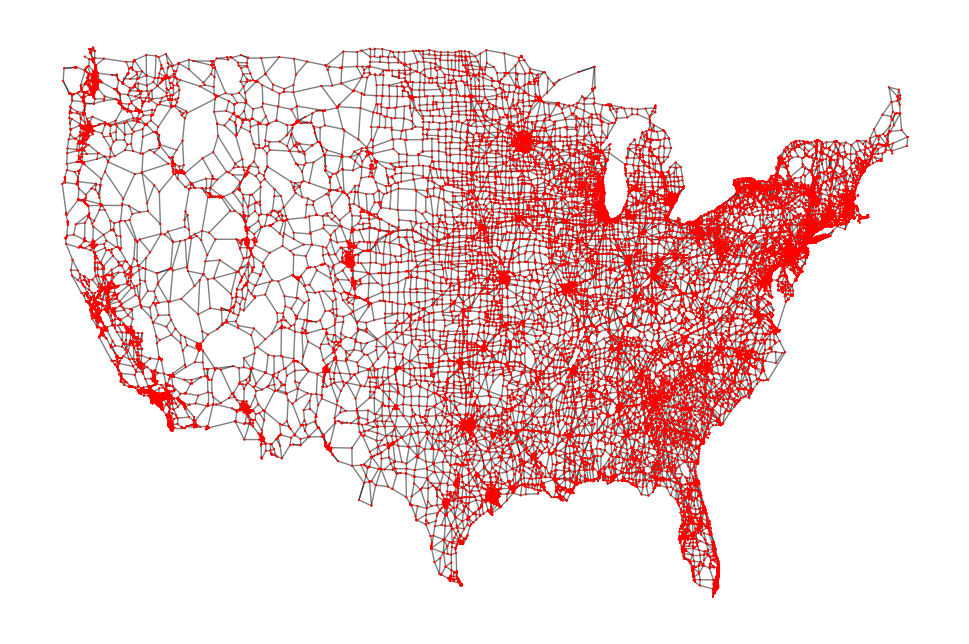

In [3]:
g = lgc.GraphLocal()
g.read_graph("usroads-simplify.edges", separator="\t")
xy = np.loadtxt("usroads-simplify.xy")
g.draw(xy,nodesize=0.5,edgealpha=0.5,linewidth=0.5)

In [4]:
## Get cities mapped
cities_str="""New York	1	New York	4.8	8405837	40.7127837	-74.0059413
Los Angeles	2	California	4.8	3884307	34.0522342	-118.2436849
Chicago	3	Illinois	-6.1	2718782	41.8781136	-87.6297982
Houston	4	Texas	11	2195914	29.7604267	-95.3698028
Philadelphia	5	Pennsylvania	2.6	1553165	39.9525839	-75.1652215
Phoenix	6	Arizona	14	1513367	33.4483771	-112.0740373
San Antonio	7	Texas	21	1409019	29.4241219	-98.4936282
San Diego	8	California	10.5	1355896	32.715738	-117.1610838
Dallas	9	Texas	5.6	1257676	32.7766642	-96.7969879
San Jose	10	California	10.5	998537	37.3382082	-121.8863286
Austin	11	Texas	31.7	885400	30.267153	-97.7430608
Indianapolis	12	Indiana	7.8	843393	39.768403	-86.158068
Jacksonville	13	Florida	14.3	842583	30.3321838	-81.655651
San Francisco	14	California	7.7	837442	37.7749295	-122.4194155
Columbus	15	Ohio	14.8	822553	39.9611755	-82.9987942
Charlotte	16	North Carolina	39.1	792862	35.2270869	-80.8431267
Fort Worth	17	Texas	45.1	792727	32.7554883	-97.3307658
Detroit	18	Michigan	-27.1	688701	42.331427	-83.0457538
El Paso	19	Texas	19.4	674433	31.7775757	-106.4424559
Memphis	20	Tennessee	-5.3	653450	35.1495343	-90.0489801
Seattle	21	Washington	15.6	652405	47.6062095	-122.3320708
Denver	22	Colorado	16.7	649495	39.7392358	-104.990251
Washington	23	District of Columbia	13	646449	38.9071923	-77.0368707
Boston	24	Massachusetts	9.4	645966	42.3600825	-71.0588801
Nashville	25	Tennessee	16.2	634464	36.1626638	-86.7816016
Baltimore	26	Maryland	-4	622104	39.2903848	-76.6121893
Oklahoma City	27	Oklahoma	20.2	610613	35.4675602	-97.5164276
Louisville	28	Kentucky	10	609893	38.2526647	-85.7584557
Portland	29	Oregon	15	609456	45.5230622	-122.6764816
Las Vegas	30	Nevada	24.5	603488	36.1699412	-115.1398296
Milwaukee	31	Wisconsin	0.3	599164	43.0389025	-87.9064736
Albuquerque	32	New Mexico	23.5	556495	35.0853336	-106.6055534
Tucson	33	Arizona	7.5	526116	32.2217429	-110.926479
Fresno	34	California	18.3	509924	36.7468422	-119.7725868
Sacramento	35	California	17.2	479686	38.5815719	-121.4943996
Long Beach	36	California	1.5	469428	33.7700504	-118.1937395
Kansas City	37	Missouri	5.5	467007	39.0997265	-94.5785667
Mesa	38	Arizona	13.5	457587	33.4151843	-111.8314724
Virginia Beach	39	Virginia	5.1	448479	36.8529263	-75.977985
Atlanta	40	Georgia	6.2	447841	33.7489954	-84.3879824
Colorado Springs	41	Colorado	21.4	439886	38.8338816	-104.8213634
Omaha	42	Nebraska	5.9	434353	41.2523634	-95.9979883
Raleigh	43	North Carolina	48.7	431746	35.7795897	-78.6381787
Miami	44	Florida	14.9	417650	25.7616798	-80.1917902
Oakland	45	California	1.3	406253	37.8043637	-122.2711137
Minneapolis	46	Minnesota	4.5	400070	44.977753	-93.2650108
Tulsa	47	Oklahoma	1.3	398121	36.1539816	-95.992775
Cleveland	48	Ohio	-18.1	390113	41.49932	-81.6943605
Wichita	49	Kansas	9.7	386552	37.688889	-97.336111""".split("\n")
cities=[]
for citystr in cities_str:
  parts = citystr.split("\t")
  name = parts[0]
  xc = float(parts[5])
  yc = float(parts[6])
  xyc = np.array([yc,xc])
  dists = np.sum((xy - xyc)**2,axis=1) 
  node = np.sum((xy - xyc)**2,axis=1).argmin()
  cities.append((name, node))

In [5]:
def label_city(xy, name):
    for c in cities:
        if c[0] == name:
            xc = xy[c[1],0]
            yc = xy[c[1],1]
            text = plt.text(xc,yc,c[0],fontsize=8,
                          color='white',
                          ha='center', va='center')
            text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                       path_effects.Normal()])

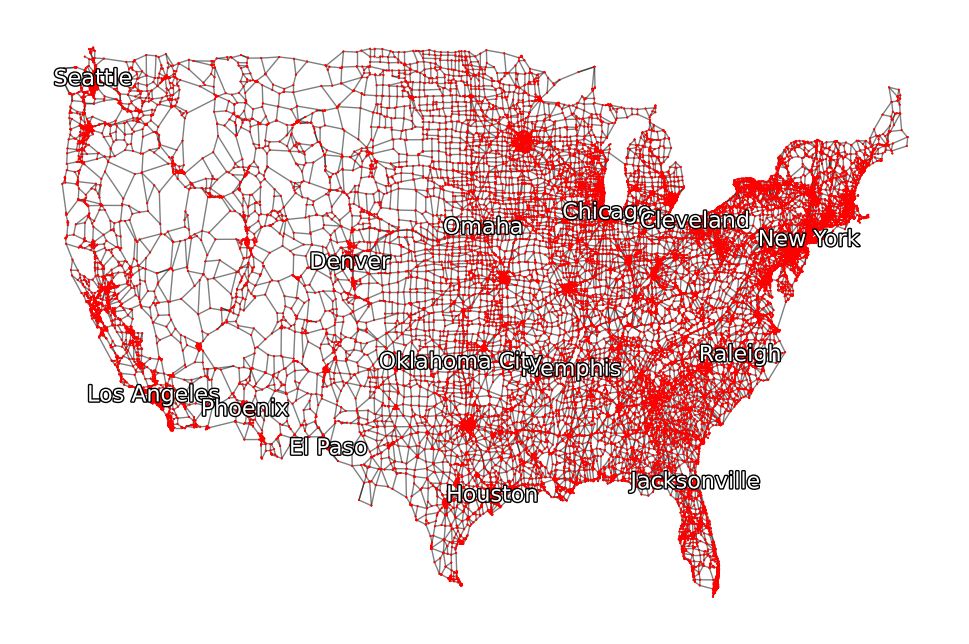

In [6]:
def label_cities(xy, thresh=0.1):
    # we plot cities assuming your at least 10% away from previous points. 
    xrange = np.max(xy[:,0])-np.min(xy[:,0])
    yrange = np.max(xy[:,1])-np.min(xy[:,1])
    refrange = max(xrange,yrange)
    plotted = [] # the list of plotted cities
    for c in cities:
        xc = xy[c[1],0]
        yc = xy[c[1],1]
        # compute relative distance in x, y
        mindist = refrange # find the closed plotted city
        for p in plotted:
            d = np.sqrt((p[0]-xc)**2 + (p[1]-yc)**2)
            if d < mindist:
                mindist = d
        if mindist/refrange > thresh:
            #plt.text(xc,yc,c[0],fontsize=10)
            text = plt.text(xc,yc,c[0],fontsize=8,
                          color='white',
                          ha='center', va='center')
            text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                       path_effects.Normal()])
            plotted.append((xc,yc))
g.draw(xy,nodesize=0.5,edgealpha=0.5,linewidth=0.5)
label_cities(xy)

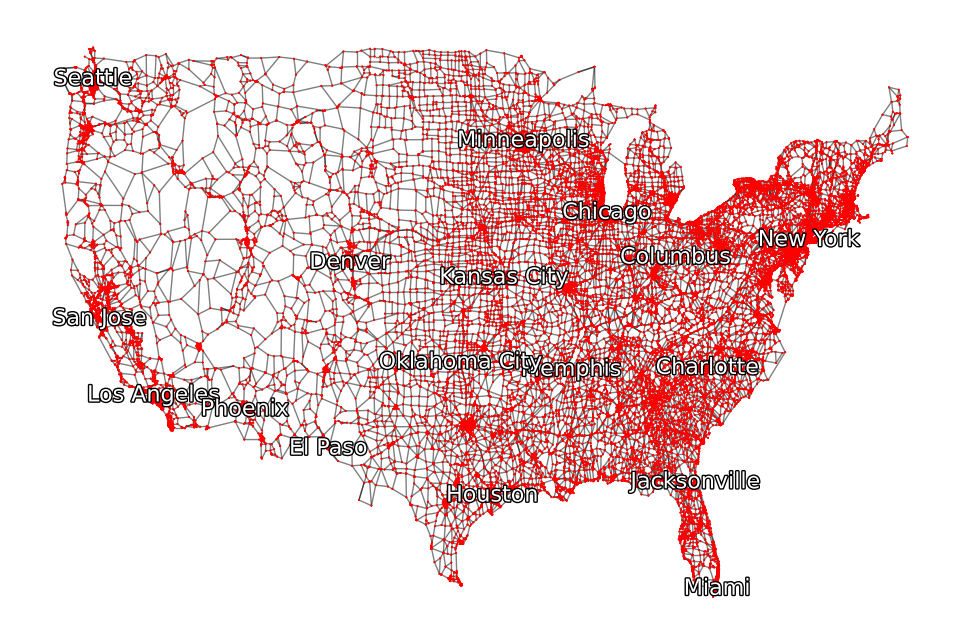

In [7]:
g.draw(xy,nodesize=0.5,edgealpha=0.5,linewidth=0.5)
label_cities(xy, thresh=0.08)

In [8]:
# Laplacian eigenvectors, adapted fro lgc
import numpy as np
import scipy as sp
import scipy.sparse.linalg as splinalg

def eig2_nL(g, tol_eigs = 1.0e-6, normalize:bool = True, dim:int=1):    
    n = g.adjacency_matrix.shape[0]

    D_sqrt_neg = sp.sparse.spdiags(g.dn_sqrt.transpose(), 0, n, n)

    L = sp.sparse.identity(n) - D_sqrt_neg.dot((g.adjacency_matrix.dot(D_sqrt_neg)))

    emb_eig_val, p = splinalg.eigsh(L, which='SM', k=1+dim, tol = tol_eigs)

    F = np.real(p[:,0:])
    if normalize:
        F *= g.dn_sqrt[:,np.newaxis]
    return F, emb_eig_val

def eig2_L(g, tol_eigs = 1.0e-6, normalize:bool = True, dim:int=1):    
    n = g.adjacency_matrix.shape[0]

    L = sp.sparse.spdiags(g.d, 0, n, n) - g.adjacency_matrix

    emb_eig_val, p = splinalg.eigsh(L, which='SM', k=1+dim, tol = tol_eigs)

    F = np.real(p[:,0:])
    if normalize:
        F *= g.dn_sqrt[:,np.newaxis]
    return F, emb_eig_val


In [9]:
# We want to try the trivial one too
V,vals = eig2_L(g, dim=5, tol_eigs=1e-4, normalize=False)
V,vals

(array([[-0.00442184, -0.0067047 ,  0.00491174, -0.00060711,  0.01719805,
          0.00177637],
        [-0.00442184, -0.0067066 ,  0.00491508, -0.0006067 ,  0.01722035,
          0.00177871],
        [-0.00442184, -0.00329618, -0.00091569, -0.00453287,  0.00210061,
         -0.00060072],
        ...,
        [-0.00442184,  0.00174085, -0.0076048 ,  0.01936605,  0.00444027,
          0.00584226],
        [-0.00442184,  0.00174085, -0.0076048 ,  0.01936607,  0.00444028,
          0.00584227],
        [-0.00442184,  0.00174092, -0.00760546,  0.0193694 ,  0.00444124,
          0.00584372]]),
 array([-1.75521631e-16,  3.79189124e-05,  8.69140201e-05,  1.71790332e-04,
         2.17500192e-04,  2.48849455e-04]))

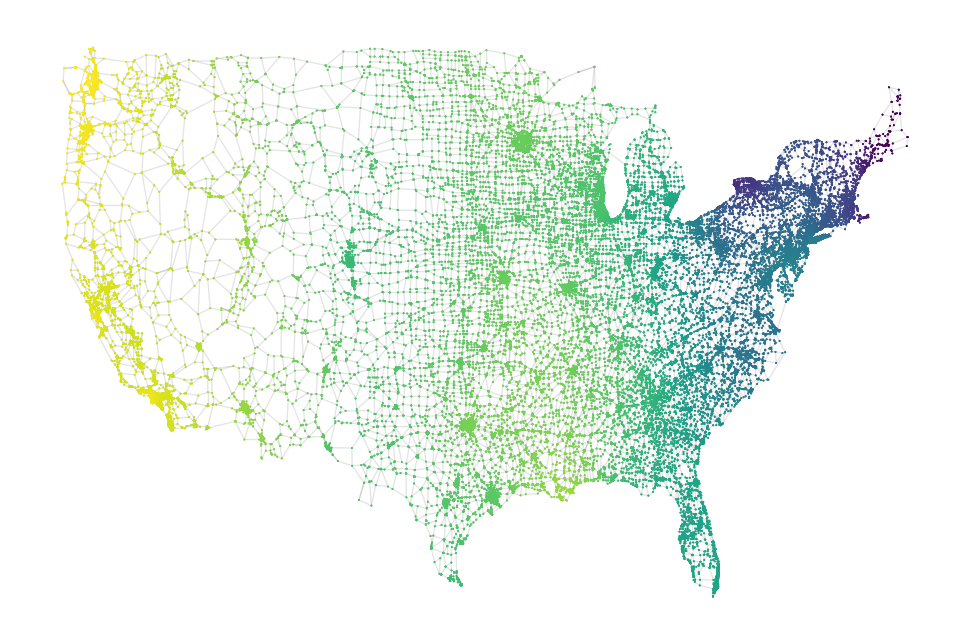

In [10]:
g.draw(xy,nodesize=0.5,edgealpha=0.1,linewidth=0.5,nodecolor=V[:,0])

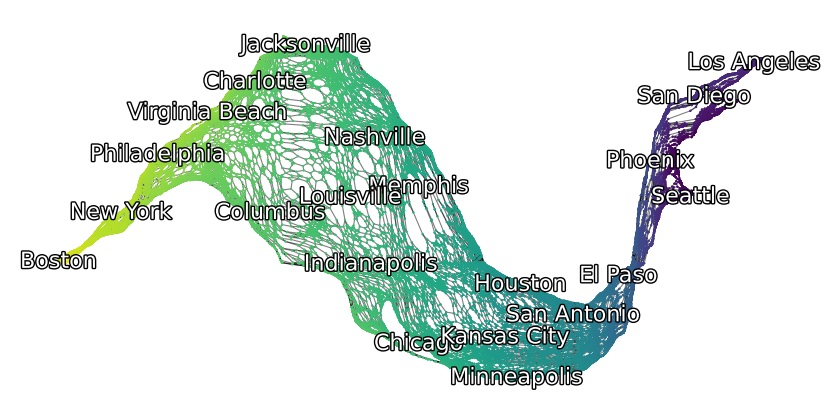

In [11]:
# use the permutation from each vector to linearize the embedding 
# https://stackoverflow.com/questions/11649577/how-to-invert-a-permutation-array-in-numpy
def invert_permutation(p):
    s = np.empty(p.size, p.dtype)
    s[p] = np.arange(p.size)
    return s
# the negative sign in V[:,1] is just to get NYC /Boston on the right 
P = np.array([invert_permutation(np.argsort(-V[:,1])),invert_permutation(np.argsort(V[:,3]))]).T
drawing = g.draw(P,nodesize=0.6,edgealpha=0.5,linewidth=0.4,nodecolor=xy[:,0])
label_cities(P,thresh=0.1)
drawing.fig.set_size_inches(5,2.5)
plt.savefig('usroads-spectral-embed-1-3.pdf', bbox_inches='tight',pad_inches = 0)
plt.savefig('usroads-spectral-embed-1-3.png', dpi=300,bbox_inches='tight',pad_inches = 0)

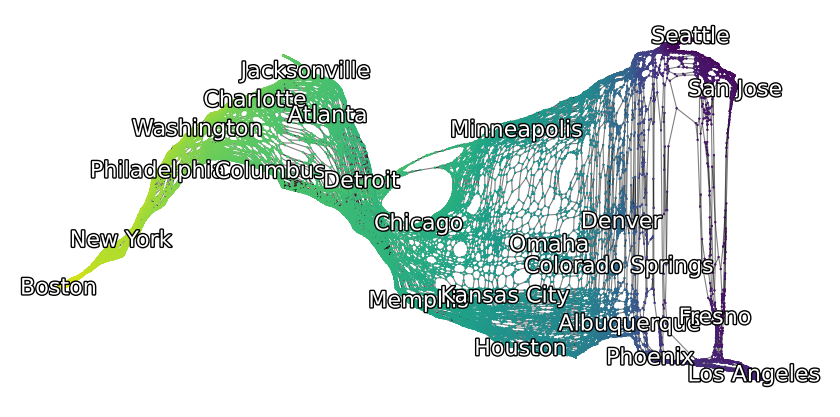

In [18]:
# the negative sign in V[:,1] is just to get NYC /Boston on the right 
P = np.array([invert_permutation(np.argsort(-V[:,1])),invert_permutation(np.argsort(V[:,4]))]).T
drawing = g.draw(P,nodesize=0.6,edgealpha=0.5,linewidth=0.4,nodecolor=xy[:,0])
label_cities(P,thresh=0.1)
drawing.fig.set_size_inches(5,2.5)
plt.savefig('usroads-spectral-embed-1-4.pdf', bbox_inches='tight',pad_inches = 0)
plt.savefig('usroads-spectral-embed-1-4.png', dpi=300,bbox_inches='tight',pad_inches = 0)

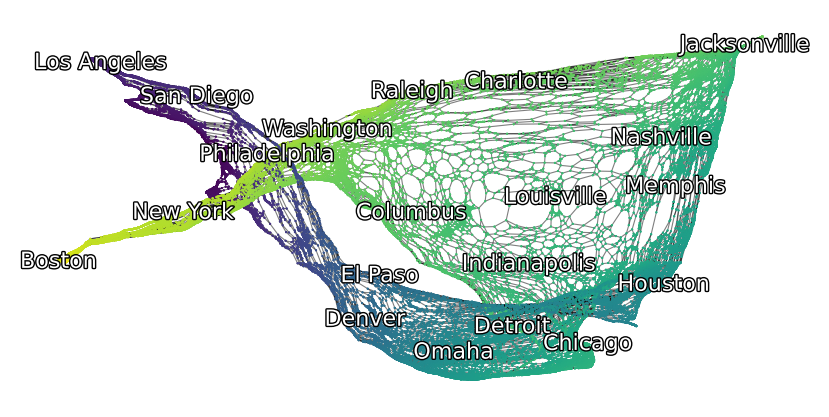

In [19]:
# the negative sign in V[:,1] is just to get NYC /Boston on the right 
P = np.array([invert_permutation(np.argsort(-V[:,2])),invert_permutation(np.argsort(V[:,3]))]).T
drawing = g.draw(P,nodesize=0.6,edgealpha=0.5,linewidth=0.4,nodecolor=xy[:,0])
label_cities(P,thresh=0.1)
drawing.fig.set_size_inches(5,2.5)
plt.savefig('usroads-spectral-embed-2-3.pdf', bbox_inches='tight',pad_inches = 0)
plt.savefig('usroads-spectral-embed-2-3.png', dpi=300,bbox_inches='tight',pad_inches = 0)

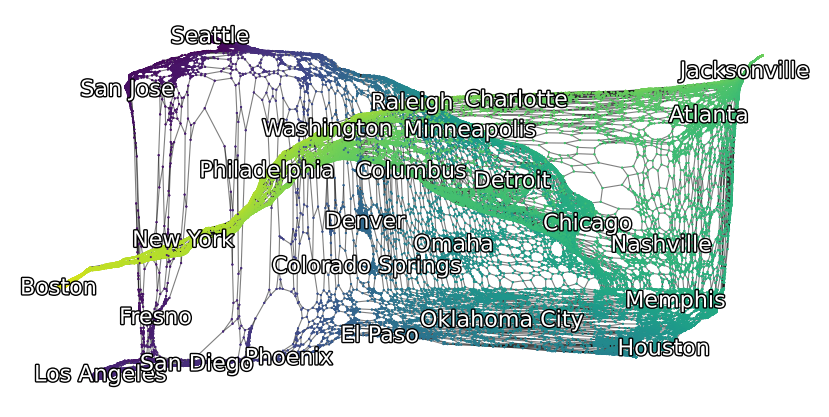

In [20]:
# the negative sign in V[:,1] is just to get NYC /Boston on the right 
P = np.array([invert_permutation(np.argsort(-V[:,2])),invert_permutation(np.argsort(V[:,4]))]).T
drawing = g.draw(P,nodesize=0.6,edgealpha=0.5,linewidth=0.4,nodecolor=xy[:,0])
label_cities(P,thresh=0.1)
drawing.fig.set_size_inches(5,2.5)
plt.savefig('usroads-spectral-embed-2-4.pdf', bbox_inches='tight',pad_inches = 0)
plt.savefig('usroads-spectral-embed-2-4.png', dpi=300,bbox_inches='tight',pad_inches = 0)

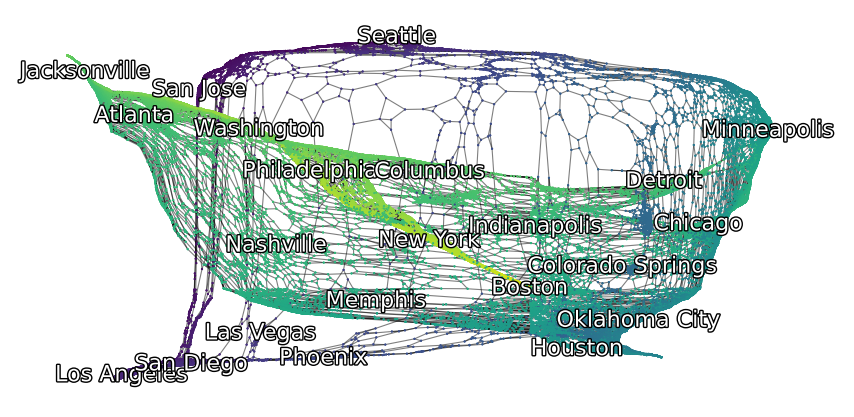

In [21]:
# the negative sign in V[:,1] is just to get NYC /Boston on the right 
P = np.array([invert_permutation(np.argsort(-V[:,3])),invert_permutation(np.argsort(V[:,4]))]).T
drawing = g.draw(P,nodesize=0.6,edgealpha=0.5,linewidth=0.4,nodecolor=xy[:,0])
label_cities(P,thresh=0.1)
drawing.fig.set_size_inches(5,2.5)
plt.savefig('usroads-spectral-embed-3-4.pdf', bbox_inches='tight',pad_inches = 0)
plt.savefig('usroads-spectral-embed-3-4.png', dpi=300,bbox_inches='tight',pad_inches = 0)

This is the end of the list of eigenvectors for the reviewer